# Using a Transferred DCNN (VGG16). 

*   Take a DCNN trained on image classification
*   Adapt to spectrogram classification
*   Training and testing data from all
actions and test subjects, but 0 degrees aspect angle;
  




Inspired by "Micro-Doppler Based Classification of Human Aquatic Activities via Transfer Learning of Convolutional Neural Networks"

## Notebook setup

Allow editing of modules using editor (auto reloading)

In [0]:
# Needed to allow editing using PyCharm
%load_ext autoreload
%autoreload 2

Needed for compatibility when using both CoLab and Local Jupyter notebook. It sets the appropriate file path for the data and also installs local packages such as models and data_loading.

In [2]:
import os
if os.getcwd() == '/content':
    from google.colab import drive
    drive.mount('/content/gdrive')
    BASE_PATH = '/content/gdrive/My Drive/Level-4-Project/'
    !cd gdrive/My\ Drive/Level-4-Project/ && pip install --editable .
    os.chdir('gdrive/My Drive/Level-4-Project/')
    
elif os.getcwd() == 'C:\\Users\\macka\\Google Drive\\Level-4-Project\\notebooks\\transferred_DCNN_experiments':
    BASE_PATH = "C:/Users/macka/Google Drive/Level-4-Project/"
    
else:
    BASE_PATH = "/export/home/2192793m/Level-4-Project/"
    
DATA_PATH = BASE_PATH + 'data/'
MODEL_PATH = BASE_PATH + 'models/transferred_DCNN/'
FIGURE_PATH = BASE_PATH + 'reports/figures/transferred_DCNN/'
REPORT_PATH = BASE_PATH + 'reports/transferred_DCNN/'
    
from src.models.original_models import cnn_various_depths
from src.data import load_data
from src.visualization import visualize, multiple_plots

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Obtaining file:///content/gdrive/My%20Drive/Level-4-Project
  Found existing installation: src 0.1.0
    Can't uninstall 'src'. No files were found to uninstall.
  Running setup.py develop for src


Using TensorFlow backend.


Import remaining packages

In [0]:
import numpy as np
import sys
from six.moves import cPickle
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.utils import np_utils
import sys
from sklearn.metrics import classification_report, confusion_matrix
import csv
from keras.models import load_model
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Dropout, Flatten
from keras.models import Model
from sklearn.model_selection import StratifiedKFold

In [0]:
# Needed as originally code was for theano backend but now using tensor flow
from keras import backend as K
K.set_image_dim_ordering('th')

## Experiment Setup and Parameter Definition

### Experiment Togggles

In [0]:
load_models = False  # if True, load saved models instead of retraining
train_model_using_k_fold = False
save_graph = False
save_models = False
save_reports = False

### Parameter Definition

In [0]:
batch_size = 100
nb_classes = 7
nb_epoch = 10
#nb_train_samples = 35595
nb_train_samples = 34720

n_folds = 3 # number of folds for k-fold cross validation

# input image dimensions (images are spectrograms)
img_rows, img_cols = 75, 75

In [0]:
data_folders = {'1s':{}, '1_5s':{}, '2s':{}, 'noninitialised_A':{}} # maybe chaneg to cifar initlaizzed
for key, value in data_folders.items():
    value["acc"] = None
    value["loss"] = None
    value["classification_report"] = None
    value["confusion_matrix"] = None

### Data Loading

In [0]:
# the data, shuffled and split between train and test sets
(data_train, labels_train), (data_test, labels_test) = load_data.load_data(DATA_PATH+"1s", nb_train_samples)

In [0]:
target_names = ['ArmFasterTowards', 'ArmSlowerTowards', 'CirclingArm', 'Clapping', 'PickingUp', 'Sitting', 'Walking']

Stack three times to fit VGG16 (RGB) treated as grayscale

In [0]:
data_train = np.hstack((data_train, data_train, data_train))
data_test = np.hstack((data_test, data_test, data_test))

In [0]:
def make_model(img_rows, img_cols, nb_classes):
    model = VGG16(weights = "imagenet", include_top=False, input_shape=(3, img_rows, img_cols))
    x = model.output
    x = Flatten()(x)
    # x = Dense(512, activation="relu")(x)
    x = Dense(1024, activation="relu")(x)
    x = Dropout(0.5)(x)
    # x = Dense(512, activation="relu")(x)
    x = Dense(1024, activation="relu")(x)
    predictions = Dense(nb_classes, activation="softmax")(x)
    model = Model(input = model.input, output = predictions)
    sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss = "categorical_crossentropy", optimizer = sgd, metrics=["accuracy"])
    return model

In [0]:
# set type and normalize the data
def process_train_test_data(data_train, data_test):
    data_train = data_train.astype('float32')
    data_test = data_test.astype('float32')
    data_train /= 255
    data_test /= 255
    return data_train, data_test

In [0]:
# convert class vectors to binary class matrices
def process_train_test_labels(labels_train, labels_test, nb_classes):
    labels_train = np_utils.to_categorical(labels_train, nb_classes)
    labels_test = np_utils.to_categorical(labels_test, nb_classes)
    return labels_train, labels_test

## Training and Evaluating Models

In [0]:
def train_and_evaluate_model(model, data_train, labels_train, data_test, labels_test, target_names, nb_classes):
    labels_train, labels_test = process_train_test_labels(labels_train, labels_test, nb_classes)
    data_train, data_test = process_train_test_data(data_train, data_test)
    
    history = model.fit(
        data_train,
        labels_train,
        batch_size=batch_size,
        epochs=nb_epoch,
        validation_data=(data_test, labels_test),
        shuffle=True, 
        verbose=1)
    # make prediction on test set
    y_pred = np.argmax(model.predict(data_test),axis=1)
    classification_rep = classification_report(np.argmax(labels_test,axis=1), y_pred, target_names=target_names)
    confusion = confusion_matrix(np.argmax(labels_test,axis=1), y_pred)  
    # return the results
    return {
        "history":history,
        "classification_report":classification_rep,
        "confusion_matrix":confusion,
        "model": model
    }

### K-Fold Cross Validation

In [0]:
if train_model_using_k_fold:
    # combine train and test sets as k-folds splits these instead
    data_train = np.vstack((data_train, data_test))
    labels_train = np.vstack((labels_train, labels_test))
    skf = StratifiedKFold(n_splits=n_folds, random_state=None, shuffle=True)
    fold_num = 1
    results = {}
    for train_index, test_index in skf.split(X_train, y_train):
        print ("Running Fold", fold_num, "/", n_folds)
        model = None # Clearing the NN.
        model = make_model(img_rows, img_cols, nb_classes)
        fold_results = train_and_evaluate_model(
            model,
            data_train[train_index],
            labels_train[train_index],
            data_train[test_index],
            labels_train[test_index],
            target_names,
            nb_classes)
        results[fold_num] = fold_results
        fold_num+=1

### Train model on all training data

In [47]:
if not train_model_using_k_fold:
    model = make_model(img_rows, img_cols, nb_classes)
    results = train_and_evaluate_model(
        model,
        data_train,
        labels_train,
        data_test,
        labels_test,
        target_names,
        nb_classes)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  # This is added back by InteractiveShellApp.init_path()


Train on 34720 samples, validate on 6944 samples
Epoch 1/10
34720/34720 [==============================] - 144s 4ms/step - loss: 0.8524 - acc: 0.6888 - val_loss: 2.3324 - val_acc: 0.4312
Epoch 2/10
34720/34720 [==============================] - 143s 4ms/step - loss: 0.0661 - acc: 0.9790 - val_loss: 2.7670 - val_acc: 0.4245
Epoch 3/10
34720/34720 [==============================] - 143s 4ms/step - loss: 0.0265 - acc: 0.9922 - val_loss: 3.1042 - val_acc: 0.4211
Epoch 4/10
34720/34720 [==============================] - 143s 4ms/step - loss: 0.0145 - acc: 0.9959 - val_loss: 3.1670 - val_acc: 0.4297
Epoch 5/10
34720/34720 [==============================] - 144s 4ms/step - loss: 0.0093 - acc: 0.9974 - val_loss: 3.2288 - val_acc: 0.4050
Epoch 6/10
34720/34720 [==============================] - 143s 4ms/step - loss: 0.0067 - acc: 0.9984 - val_loss: 3.5520 - val_acc: 0.4011
Epoch 7/10
34720/34720 [==============================] - 144s 4ms/step - loss: 0.0047 - acc: 0.9989 - val_loss: 3.7422 - v

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [48]:
for folder_name, value in data_folders.items():    
    X_test, y_test = load_data.load_batch(DATA_PATH + folder_name + '/test_batch')
    y_test = np.reshape(y_test, (len(y_test), 1))
    Y_test = np_utils.to_categorical(y_test, nb_classes)
    X_test = np.hstack((X_test, X_test, X_test))
    evaluation = model.evaluate(X_test, Y_test, batch_size=batch_size, verbose=1)
    value["loss"] = evaluation[0]
    value["accuracy"] = evaluation[1]
    y_pred = np.argmax(model.predict(X_test),axis=1)
    value["classification_report"] = classification_report(
        np.argmax(Y_test,axis=1),
        y_pred,target_names=target_names)
    value["confusion_matrix"] = confusion_matrix(
        np.argmax(Y_test,axis=1), y_pred)

6944/6944 [==============================] - 9s 1ms/step


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


6944/6944 [==============================] - 9s 1ms/step


## Analysis and Saving of Results

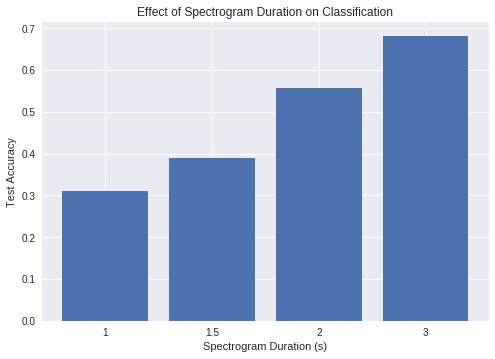

In [36]:
visualize.plot_evaluation_bar(
    data_folders,
    ['1','1.5', '2', '3'],
    "Effect of Spectrogram Duration on Classification",
    'Spectrogram Duration (s)',
    'Test Accuracy',
    save=False,
    path=FIGURE_PATH + "accuracy.svg")

In [0]:
if train_model_using_k_fold: 
    for fold, result in results.items():
        print("Fold: ", fold)
        print(result["classification_report"])
        print("- - - - - - - - - - - - - - - - - - - -")

Fold:  1
                  precision    recall  f1-score   support

ArmFasterTowards       0.99      1.00      1.00      1695
ArmSlowerTowards       1.00      1.00      1.00      1695
     CirclingArm       1.00      0.99      0.99      1695
        Clapping       1.00      1.00      1.00      1695
       PickingUp       1.00      0.99      0.99      1695
         Sitting       0.99      1.00      0.99      1695
         Walking       1.00      1.00      1.00      1695

     avg / total       1.00      1.00      1.00     11865

- - - - - - - - - - - - - - - - - - - -
Fold:  2
                  precision    recall  f1-score   support

ArmFasterTowards       1.00      1.00      1.00      1695
ArmSlowerTowards       1.00      1.00      1.00      1695
     CirclingArm       1.00      1.00      1.00      1695
        Clapping       1.00      1.00      1.00      1695
       PickingUp       0.99      0.99      0.99      1695
         Sitting       1.00      0.99      1.00      1695
         W

In [0]:
if not train_model_using_k_fold: 
    print(results["classification_report"])

Fold:  1
                  precision    recall  f1-score   support

ArmFasterTowards       0.99      1.00      1.00      1695
ArmSlowerTowards       1.00      1.00      1.00      1695
     CirclingArm       1.00      0.99      0.99      1695
        Clapping       1.00      1.00      1.00      1695
       PickingUp       1.00      0.99      0.99      1695
         Sitting       0.99      1.00      0.99      1695
         Walking       1.00      1.00      1.00      1695

     avg / total       1.00      1.00      1.00     11865

- - - - - - - - - - - - - - - - - - - -
Fold:  2
                  precision    recall  f1-score   support

ArmFasterTowards       1.00      1.00      1.00      1695
ArmSlowerTowards       1.00      1.00      1.00      1695
     CirclingArm       1.00      1.00      1.00      1695
        Clapping       1.00      1.00      1.00      1695
       PickingUp       0.99      0.99      0.99      1695
         Sitting       1.00      0.99      1.00      1695
         W

### Plot and Save graph

In [0]:
if not load_models:
    visualize.plot_train_test_acc(history)


NameError: ignored

### Save Models

In [0]:
if not load_models and save_models:
    model.save(MODEL_PATH + name + '.h5')

### Save Classification Report and Confusion Matricies

In [0]:
if save_reports:
    file = open(REPORT_PATH + 'Classification_and_Confusion.txt', 'w') 

    file.write("--------------------------------------------------\n") 
    file.write("Model Name: " + name + "\n") 
    file.write("Classification Report:\n") 
    file.write(classification_rep)
    file.write("Confusion Matrix:\n") 
    file.write(np.array2string(confusion) + "\n")

    file.close() 